# Imports

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

# Load Data

In [9]:
# List all data available
datapath = r'../assets/'
# datapath = r'/kaggle/input/ga-dengue/assets'
os.listdir(datapath)

['text.md',
 'datagov_dengue.csv',
 '.ipynb_checkpoints',
 'google_trend_dengue.csv',
 'google_trend_dengue_symptoms.csv',
 'jao_dengue.csv',
 'NEA_weather.csv',
 'datagov_weather.csv',
 'NEA_dengue.csv']

Loading all data for cleaning and compiling

In [11]:
# Dengue
df_dengue_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_dengue.csv'))
df_dengue_jao_raw = pd.read_csv(os.path.join(datapath,'jao_dengue.csv'))
df_dengue_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_dengue.csv'))

# Weather
df_weather_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_weather.csv'))
df_weather_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_weather.csv'))

# Google trend
df_trend_dengue_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue.csv'))
df_trend_dengue_symptoms_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue_symptoms.csv'))

We first clean and compile the available __dengue__ data. Most years have 52 or 53 weeks, while 2024 only has 27 weeks so far. 2019 has some missing entries which will require some imputation later.

In [12]:
# Clean and compile dengue data
df_dengue_datagov = df_dengue_datagov_raw.copy()
df_dengue_datagov.rename(columns={'year':'Year','eweek':'Week','number':'Dengue_Count'}, inplace=True)    # Rename columns for consistency
df_dengue_datagov = df_dengue_datagov.groupby(['Year','Week']).sum()                                      # Combine normal dengue cases and hemorrhagic cases
df_dengue_datagov = df_dengue_datagov.drop(columns='type_dengue').reset_index()                           # Drop dengue fever type

df_dengue_jao = df_dengue_jao_raw.copy()
df_dengue_jao.rename(columns={'Week No.':'Week', 'Dengue (Count)':'Dengue_Count'},inplace=True)           # Rename columns for consistency
df_dengue_jao.drop(columns=['Daily Rainfall Total (mm)','Mean Temperature (C)'],inplace=True)

df_dengue_NEA = df_dengue_NEA_raw.copy()
df_dengue_NEA = df_dengue_NEA.reset_index()
df_dengue_NEA.drop(columns='Unnamed: 0',inplace=True)
df_dengue_NEA = pd.melt(df_dengue_NEA, id_vars=['index','week'],
                        value_vars=['2020','2021','2022','2023','2024'],
                        var_name='Year', value_name='Dengue_Count')                                       # Gathering into long format for consistency
df_dengue_NEA.drop(columns=['index'],inplace=True)
df_dengue_NEA.rename(columns={'week':'Week'},inplace=True)                                                # Rename columns for consistency

df_dengue = pd.concat([df_dengue_datagov,df_dengue_NEA,df_dengue_jao],axis=0)                             # Compiling all dengue datasets into single dataframe
df_dengue.dropna(inplace=True)                                                                            # Dropping small number of missing values
df_dengue = df_dengue.astype({'Year':'int', 'Dengue_Count':'int'})                                        # Converting to standard dtypes
df_dengue.drop_duplicates(subset=['Year','Week'],inplace=True)                                            # Dropping duplicate entries from different data sources
df_dengue.sort_values(by=['Year','Week'],inplace=True)                                                    # Sort in chronological order
df_dengue.groupby(['Year']).count()

,Week,Dengue_Count
Year,,
2012,52,52
2013,52,52
2014,53,53
2015,53,53
2016,53,53
2017,53,53
2018,53,53
2019,47,47
2020,53,53


Next, we clean and compile the __weather__ data. On further inpection, we see that the datagov data consists of weather information for years from 2009 to 2017 only.

In [13]:
# Show data structure and date range
df_weather_datagov = df_weather_datagov_raw.copy()
display(df_weather_datagov.head(5))
pd.to_datetime(df_weather_datagov['date']).min(), pd.to_datetime(df_weather_datagov['date']).max()

,date,station,daily_rainfall_total,highest_30_min_rainfall,highest_60_min_rainfall,highest_120_min_rainfall,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed
0,2009-01-01,Admiralty,na,na,na,na,na,na,na,na,na
1,2009-01-02,Admiralty,na,na,na,na,na,na,na,na,na
2,2009-01-03,Admiralty,na,na,na,na,na,na,na,na,na
3,2009-01-04,Admiralty,na,na,na,na,na,na,na,na,na
4,2009-01-05,Admiralty,na,na,na,na,na,na,na,na,na


(Timestamp('2009-01-01 00:00:00'), Timestamp('2017-11-30 00:00:00'))

Since we need data from 2012 to 2024, we will not use the datagov weather data, and focus on NEA weather instead, which has been scraped from NEA for the required date range. Missing data has been encoded as -1 in this dataset. As shown, the NEA dataset contains daily weather information information from multiple weather stations.

In [14]:
df_weather_NEA = df_weather_NEA_raw.copy()
df_weather_NEA.sample(5)

,Unnamed: 0,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
72945,13,Boon Lay (East),2013,8,14,17.4,-1.0,-1.0,-1.0,27.8,29.9,24.4,5.1,31.0
185226,28,Toa Payoh,2017,3,29,31.8,30.4,31.8,31.8,-1.0,-1.0,-1.0,-1.0,-1.0
119997,29,Dhoby Ghaut,2022,7,30,0.2,0.2,0.2,0.2,-1.0,-1.0,-1.0,-1.0,-1.0
46394,12,Boon Lay (West),2013,10,13,2.6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
213657,13,Chai Chee,2019,12,14,33.4,4.8,7.6,11.8,-1.0,-1.0,-1.0,-1.0,-1.0


Our dengue dataset provides weekly dengue counts for the whole of Singapore. To match the dengue dataset, we take the mean values for the different weather conditions across different weather stations and over the week. We see that the highest rainfall columns consists of more than 100 missing values. These columns are dropped here for simplicity.

In [15]:
df_weather_NEA.columns

Index(['Unnamed: 0', 'Station', 'Year', 'Month', 'Day',
       'Daily Rainfall Total (mm)', 'Highest 30 min Rainfall (mm)',
       'Highest 60 min Rainfall (mm)', 'Highest 120 min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)'],
      dtype='object')

In [16]:
# Get week of year
df_weather_NEA = df_weather_NEA.replace(-1, np.nan)                                     # Encode missing values as NaN
df_weather_NEA.drop(columns=['Unnamed: 0'],inplace=True)                                # Drop index column
df_weather_NEA.dropna(subset=['Year','Month','Day'],inplace=True)                       # Dropping records where the date in missing
df_weather_NEA = df_weather_NEA.astype({'Year':'int','Month':'int','Day':'int'})        # Convert to date time and extract week of year
df_weather_NEA['date'] = pd.to_datetime(df_weather_NEA[['Year', 'Month', 'Day']])
df_weather_NEA['Week'] = df_weather_NEA['date'].dt.isocalendar().week
df_weather_NEA.drop(columns=['Month','Day','date','Station'],inplace=True)                        # Drop obsolete columns

# Renaming columns for convenience.
df_weather_NEA.rename(columns={'Daily Rainfall Total (mm)':'Daily_Rainfall',
                               'Highest 30 min Rainfall (mm)':'Highest_30mm_Rain',
                               'Highest 60 min Rainfall (mm)':'Highest_60mm_Rain',
                               'Highest 120 min Rainfall (mm)':'Highest_120mm_Rain',
                               'Mean Temperature (°C)':'Mean_Temperature',
                               'Maximum Temperature (°C)':'Max_Temperature',
                               'Minimum Temperature (°C)':'Min_Temperature',
                               'Mean Wind Speed (km/h)':'Min_Wind_Speed',
                               'Max Wind Speed (km/h)':'Max_Wind_speed'},inplace=True)

# Taking mean values over all stations and over all days of a given week
df_weather_NEA = df_weather_NEA.groupby(['Year','Week']).mean()

# Check for missing values and drop
print(df_weather_NEA.info())
df_weather_NEA.drop(columns=[col for col in df_weather_NEA if ('Highest' in col)], inplace=True)
df_weather = df_weather_NEA.reset_index()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 654 entries, (2012, 1) to (2024, 26)
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Daily_Rainfall      654 non-null    float64
 1   Highest_30mm_Rain   550 non-null    float64
 2   Highest_60mm_Rain   550 non-null    float64
 3   Highest_120mm_Rain  550 non-null    float64
 4   Mean_Temperature    654 non-null    float64
 5   Max_Temperature     654 non-null    float64
 6   Min_Temperature     654 non-null    float64
 7   Min_Wind_Speed      654 non-null    float64
 8   Max_Wind_speed      654 non-null    float64
dtypes: float64(9)
memory usage: 47.7 KB
None


The final dataframe to be used as weather input is as shown below.

In [17]:
df_weather.sample(5)

,Year,Week,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed
399,2019,34,0.148066,29.229358,32.921368,27.062393,11.495798,34.276471
406,2019,41,5.054875,27.933636,32.526496,25.104274,7.452941,31.246218
369,2019,4,0.464689,27.647748,31.231356,25.470339,12.234921,39.461111
148,2014,45,14.169877,27.938095,32.136508,24.861905,6.615873,33.115873
1,2012,2,3.740000,26.434783,29.797143,23.925714,8.486429,33.596429


Finally, __google search trends__ regarding dengue may indicate imminent occurence of dengue clusters. Specifically, we include search trends related to the keywords "dengue" and "dengue+symptoms".

In [18]:
# Renaming columns
df_trend_dengue = df_trend_dengue_raw.copy()
df_trend_dengue_symptoms = df_trend_dengue_symptoms_raw.copy()
df_trend_dengue.rename(columns={'dengue: (Singapore)':'Trend_Dengue'},inplace=True)
df_trend_dengue_symptoms.rename(columns={'dengue symptoms: (Singapore)':'Trend_Dengue_Symptoms'},inplace=True)

# Get week and year
df_trend_dengue['Year'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().year
df_trend_dengue['Week'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().week
df_trend_dengue_symptoms['Year'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().year
df_trend_dengue_symptoms['Week'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().week

# Combining into one dataframe
df_trends = df_trend_dengue.merge(df_trend_dengue_symptoms,how='left',on=['Week','Year'])
df_trends.drop_duplicates(subset=['Year','Week'],inplace=True) # Drop small number of repeated entries
df_trends

,Week,Trend_Dengue,Year,Trend_Dengue_Symptoms
0,52,51,2014,58
2,1,51,2015,74
3,2,51,2015,66
4,3,49,2015,60
5,4,62,2015,62
...,...,...,...,...
680,24,63,2024,59
681,25,63,2024,77
682,26,58,2024,76
683,27,57,2024,73


We combined all data we have into a single dataframe. Visualizing missing data, we see that most of them are due to consideration of a 53rd week of the year. As mentioned earlier, some weeks in 2019 are missing dengue fever counts. Here, we:
1. drop 53rd week from each year
2. fill the missing values with `.ffill` methods.

In [19]:
df_raw= df_dengue.merge(df_weather,on=['Year','Week'],how='outer').merge(df_trends,on=['Year','Week'],how='outer')
display(df_raw[df_raw.isna().any(axis=1)])   # Show rows with missing values

,Year,Week,Dengue_Count,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Trend_Dengue,Trend_Dengue_Symptoms
0,2011,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,72.0
157,2014,53,158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,2016,53,0.0,9.947647,26.211667,27.990000,24.400000,7.458333,34.603333,NaN,NaN
316,2017,53,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,2018,53,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,2019,48,NaN,13.375069,27.664486,32.569027,25.070796,7.818033,33.086066,40.0,39.0
418,2019,49,NaN,6.549143,27.418868,30.736036,25.310811,11.496610,39.640678,40.0,40.0
419,2019,50,NaN,27.321003,25.009091,27.382692,23.375000,9.198214,32.920536,39.0,35.0
420,2019,51,NaN,5.785920,26.448889,30.261458,24.387500,8.639167,30.013333,43.0,57.0
421,2019,52,NaN,2.205525,27.395050,31.543925,25.035514,10.892683,33.669106,22.0,28.0


In [20]:
# Final touches
df_raw = df_raw.loc[df_raw['Week']!=53]
df_raw.ffill(inplace=True)                                        # Fill missing values
df_raw.dropna(inplace=True)                                       # Remove straggling row with missing values
df_raw = df_raw.astype({'Week':'int','Year':'int'})               # Ensure clean datatypes

# Exploratory Data Analysis (EDA)

In [21]:
# Create copy of main dataframe and show structure
df_plot = df_raw.copy()
df_plot.sample(5)

,Year,Week,Dengue_Count,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Trend_Dengue,Trend_Dengue_Symptoms
285,2017,22,66.0,9.986705,28.922449,32.183673,26.379592,8.646154,31.558120,93.0,81.0
592,2023,13,127.0,12.535179,27.421429,31.948214,24.552679,6.829204,31.896522,57.0,77.0
52,2012,52,112.0,2.493333,26.864780,30.220000,24.881875,6.877500,28.402500,60.0,54.0
218,2016,8,511.0,2.393590,27.781746,31.589683,25.297619,11.811111,39.488889,66.0,64.0
454,2020,33,1337.0,12.051603,28.184545,31.425862,25.172414,8.468696,32.964754,59.0,61.0


In [22]:
# Confirm that there are no missing values.
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 652 entries, 1 to 660
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   652 non-null    int64  
 1   Week                   652 non-null    int64  
 2   Dengue_Count           652 non-null    float64
 3   Daily_Rainfall         652 non-null    float64
 4   Mean_Temperature       652 non-null    float64
 5   Max_Temperature        652 non-null    float64
 6   Min_Temperature        652 non-null    float64
 7   Min_Wind_Speed         652 non-null    float64
 8   Max_Wind_speed         652 non-null    float64
 9   Trend_Dengue           652 non-null    float64
 10  Trend_Dengue_Symptoms  652 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 61.1 KB


First, we look into the trends of dengue fever over the years. As shown, most years show a peak in the middle of the year, with years 2019, 2020 and 2022 showing higher than usual dengue fever cases, possibly related to Covid related lockdown. Year 2023 again shows lower dengue fever cases as lockdown restrictions are lifted. A peculiar case of low cases is shown for year 2021.

<Axes: xlabel='Week', ylabel='Dengue_Count'>

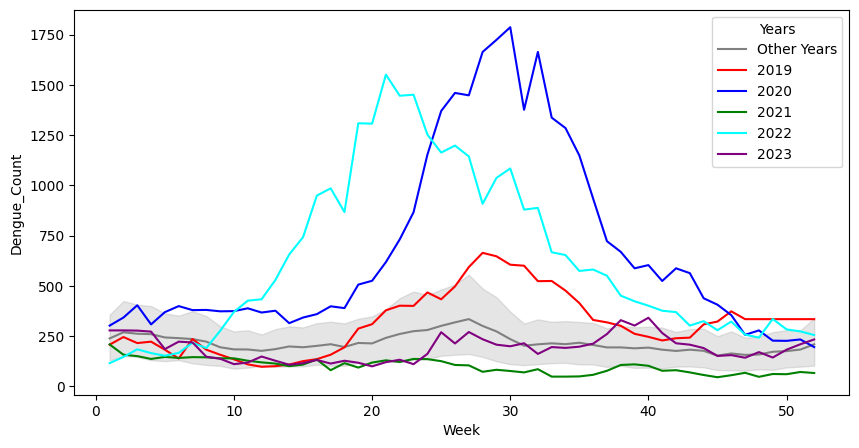

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
key_years = [2019,2020,2021,2022,2023]
df_plot['Years'] = df_plot['Year'].apply(lambda x: str(x) if x in key_years else 'Other Years')
palette = {'Other Years': 'gray', '2019': 'red', '2020':'blue','2021':'green','2022':'cyan','2023':'purple'}
sns.lineplot(data=df_plot, x='Week', y='Dengue_Count', hue='Years', palette=palette, legend=True,ax=ax)

We look at typical variation in dengue cases over a year.

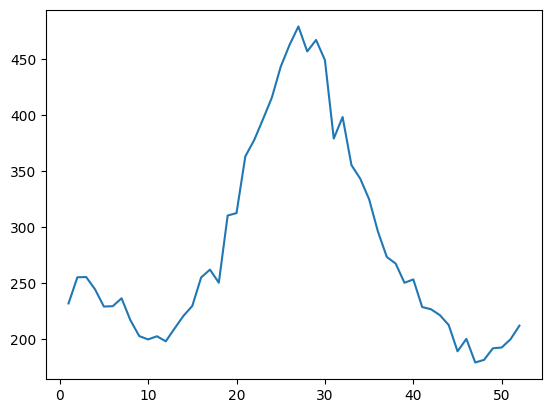

In [24]:
plt.plot(df_plot[['Week', 'Dengue_Count']].groupby('Week').mean())

Using a heatmap of linear correlation, we look at the relationship between dengue cases and the different temperature conditions. We see some correlation with temperature. However, linear relationships may not fully capture the complexity of dengue incidence in response to weather changes. In particular, dengue cases may be related to past weather conditions, as an Aedes egg can take 7 to 10 days to hatch and develop into an adult mosquito. Such relationships can be more properly explored in via statistical modelling.

<Axes: >

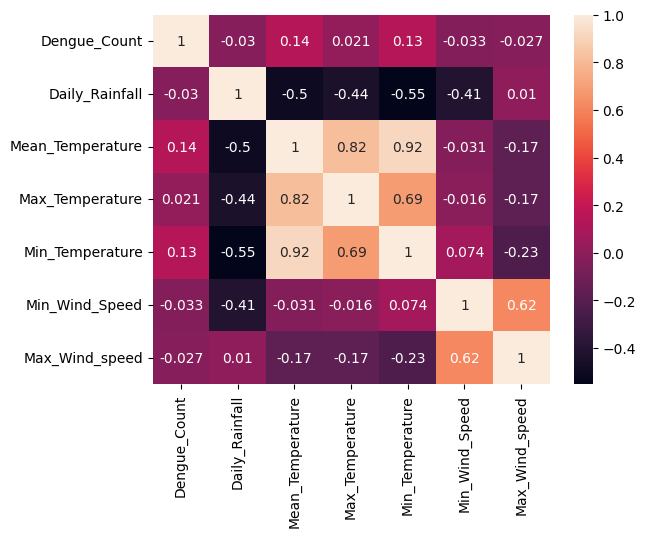

In [25]:
sns.heatmap(df_plot[['Dengue_Count','Daily_Rainfall', 'Mean_Temperature',
       'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
       'Max_Wind_speed']].corr(),annot=True)

Finally, we see if there is a relationship between google search trends on Dengue and incidence of Dengue fever. As shown, there is a strong correlation between search for Dengue symptoms and Dengue fever incidence.

<Axes: >

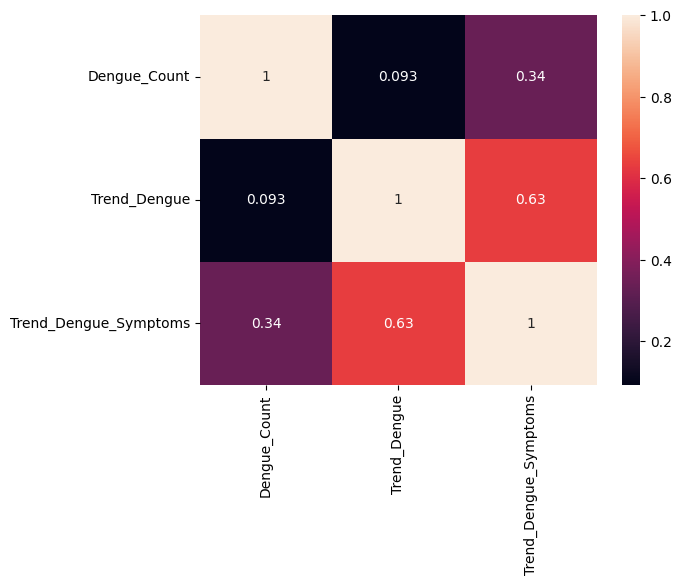

In [26]:
sns.heatmap(df_plot[['Dengue_Count','Trend_Dengue', 'Trend_Dengue_Symptoms']].corr(),annot=True)

# Modelling

## Gradient Boosted Machines (GBM) - XGBoost

### Simple First Model

We use the XGBoost model here to forecast the occurence of Dengue Fever. To do this, we need to make use of past feature values. Here, we consider a lag of 5 weeks for all features and create a model to predict dengue cases one week in the future.

In [27]:
# Make feature dataset with lagged values.
df_xgb = df_raw.copy()

lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb['Dengue_Count']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Root mean Squared Error: 209.71134500552176


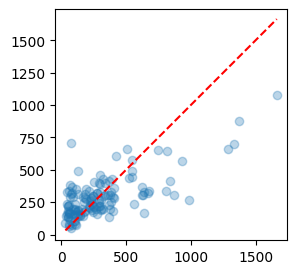

In [28]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

Feature importance plot shows that google search results are highly predictive of dengue fever occurences.

<BarContainer object of 49 artists>

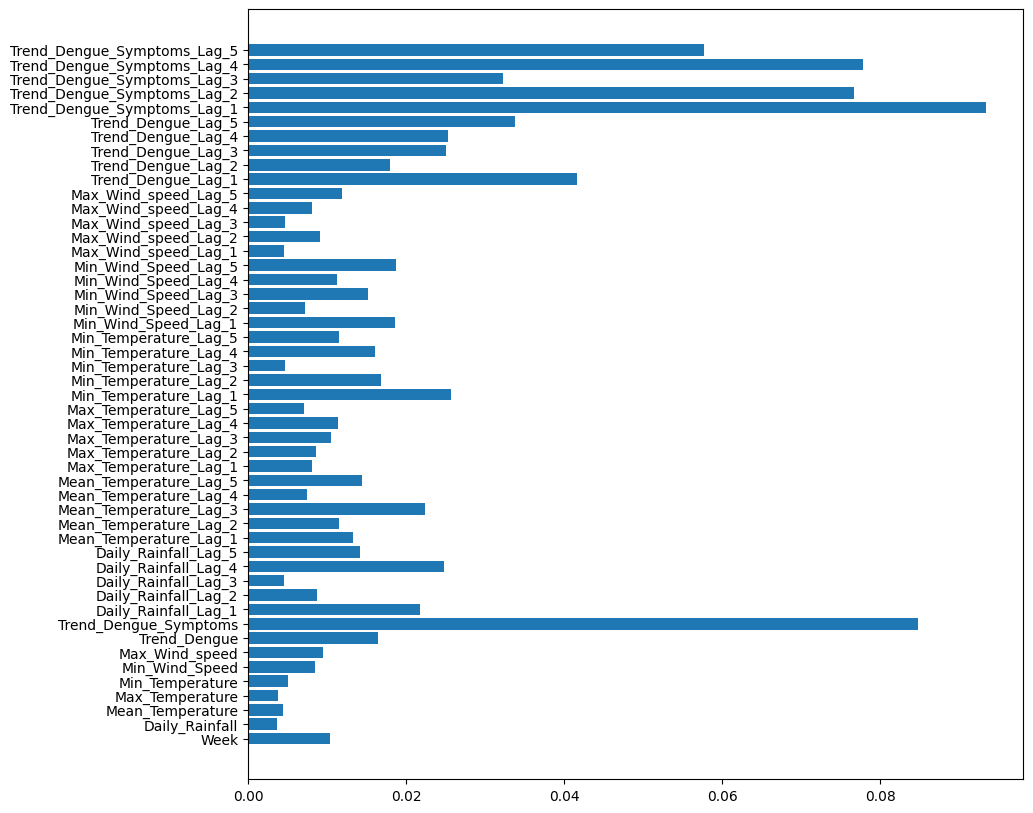

In [29]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Add events

The effect of dengue is dependent not just on prevailing weather conditions, but on external events, such as dengue control measures like the Wolbachia project or lockdown. We add these features into the existing data here.

In [30]:
# Add external events
df_xgb = df_raw.copy()

# Wolbachia efforts from Oct 2016, corresponding to week 40 of 2016 at index 250
df_xgb['Wolbachia'] = 0
df_xgb.loc[250:,'Wolbachia'] = 1

# Workplace, public events, personal gatherings restricted from 13th March 2020, corresponding to week 11 of 2020, at index 432
# DORSCON from orange to yellow on 26th April 2022, corresponding to week 18 of 2022 at index 545
# https://askabout.io/covid-19/ask/what-is-the-government-response-timeline-for-singapore/
df_xgb['Covid_Lockdown'] = 0
df_xgb.loc[432:546,'Covid_Lockdown'] = 1

# Add construction work effects?

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Wolbachia','Covid_Lockdown']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)
df_xgb.head()

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Feature importance plot shows that covid restrictions heavily affects dengue cases, with Wolbachia project having minimum impact. Dengue related search trends remain highly predictive.

Root mean Squared Error: 197.99446176787546


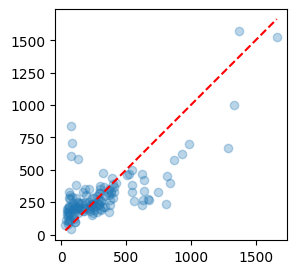

In [31]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

<BarContainer object of 61 artists>

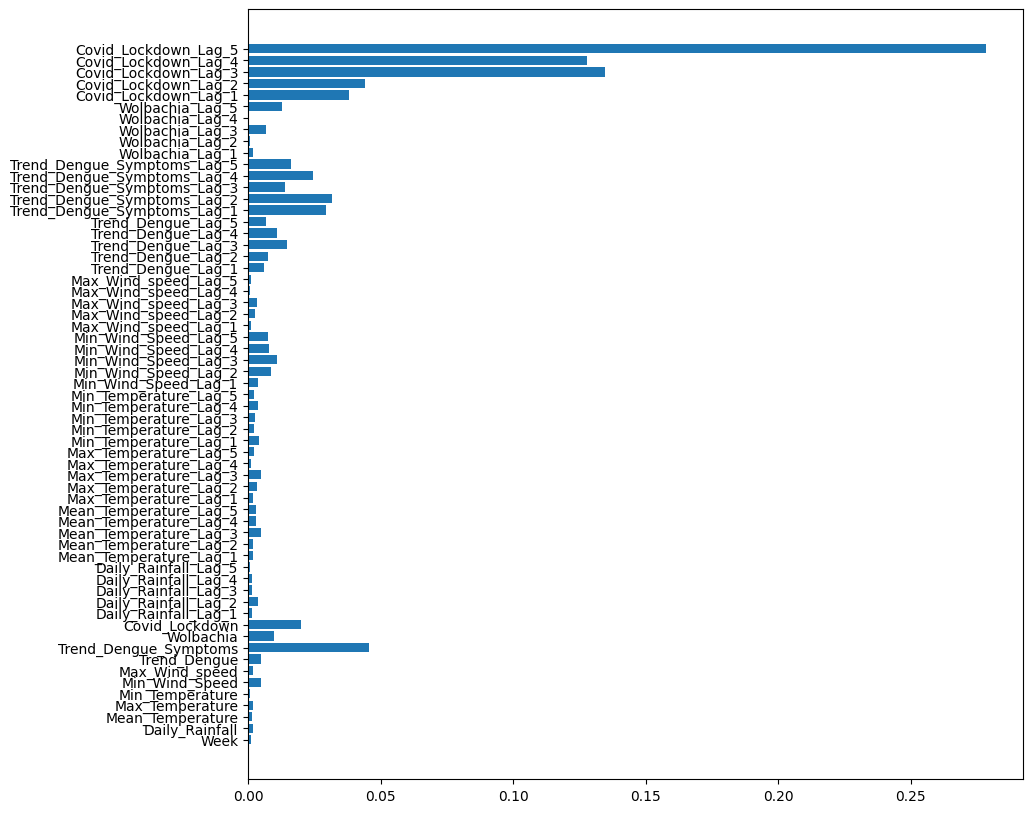

In [32]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Drop search trend features

While Google seach trends appear to be a powerful predictor of dengue cases, providing good warning signs of imminent Dengue clusters, it may have high correlation with other features, eclipsing the effects of weather conditions which are _casuing_ dengue occurence. Here, we drop search trend results from teh features for a quick assessment.

In [33]:
# Add external events
df_xgb = df_raw.copy()

# Wolbachia efforts from Oct 2016, corresponding to week 40 of 2016 at index 250
df_xgb['Wolbachia'] = 0
df_xgb.loc[250:,'Wolbachia'] = 1

# Workplace, public events, personal gatherings restricted from 13th March 2020, corresponding to week 11 of 2020, at index 432
# DORSCON from orange to yellow on 26th April 2022, corresponding to week 18 of 2022 at index 545
# https://askabout.io/covid-19/ask/what-is-the-government-response-timeline-for-singapore/
df_xgb['Covid_Lockdown'] = 0
df_xgb.loc[432:546,'Covid_Lockdown'] = 1

# Add construction work effects?

# Drop search trends
df_xgb.drop(columns=['Trend_Dengue', 'Trend_Dengue_Symptoms'],inplace=True)

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed',
                   'Wolbachia','Covid_Lockdown']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)
df_xgb.head()

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Root mean Squared Error: 282.20990320170904


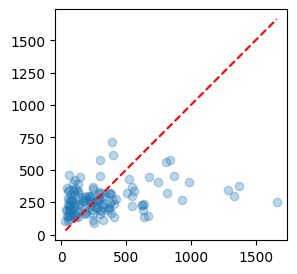

In [34]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

As expected, the accuracy of the model has fallen. Furthermore, the feature importance plot below continues to show the limited impact of Wolbachia efforts.

<BarContainer object of 49 artists>

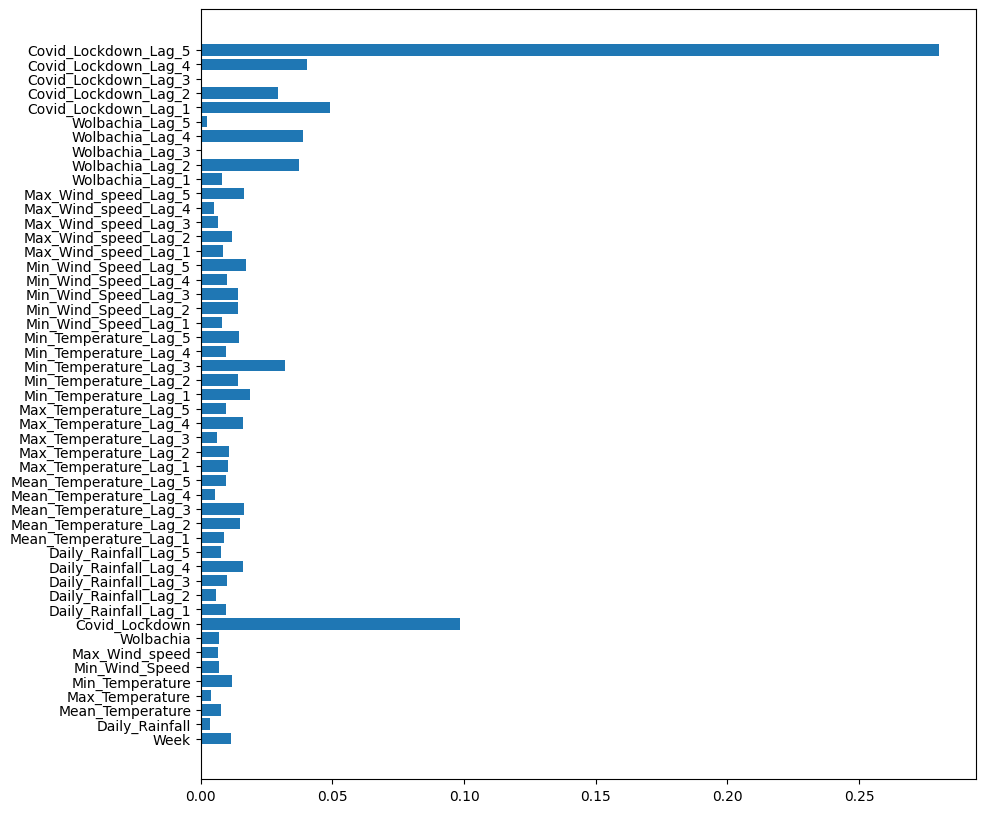

In [35]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Add lagged labels

For time series data, past data are heavily correlated with current values. This means that past dengue counts will be related to current dengue counts. Here, we add the number of past dengue cases. Search trend features are also included.

In [36]:
# Add external events
df_xgb = df_raw.copy()

# Wolbachia efforts from Oct 2016, corresponding to week 40 of 2016 at index 250
df_xgb['Wolbachia'] = 0
df_xgb.loc[250:,'Wolbachia'] = 1

# Workplace, public events, personal gatherings restricted from 13th March 2020, corresponding to week 11 of 2020, at index 432
# DORSCON from orange to yellow on 26th April 2022, corresponding to week 18 of 2022 at index 545
# https://askabout.io/covid-19/ask/what-is-the-government-response-timeline-for-singapore/
df_xgb['Covid_Lockdown'] = 0
df_xgb.loc[432:546,'Covid_Lockdown'] = 1

# Add construction work effects?

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Wolbachia','Covid_Lockdown']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = range(1, 6)
for lag in lags:
    df_xgb[f'Dengue_Count_Lag_{lag}'] = df_xgb['Dengue_Count'].shift(lag)    


# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Root mean Squared Error: 62.52596169515035


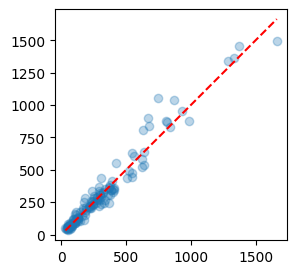

In [37]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

As shown, the presence of lagged labels drastically improves the prediction performance of the model and quickly dwarves the effects of the other features, as shown in the feature importance plot below.

<BarContainer object of 66 artists>

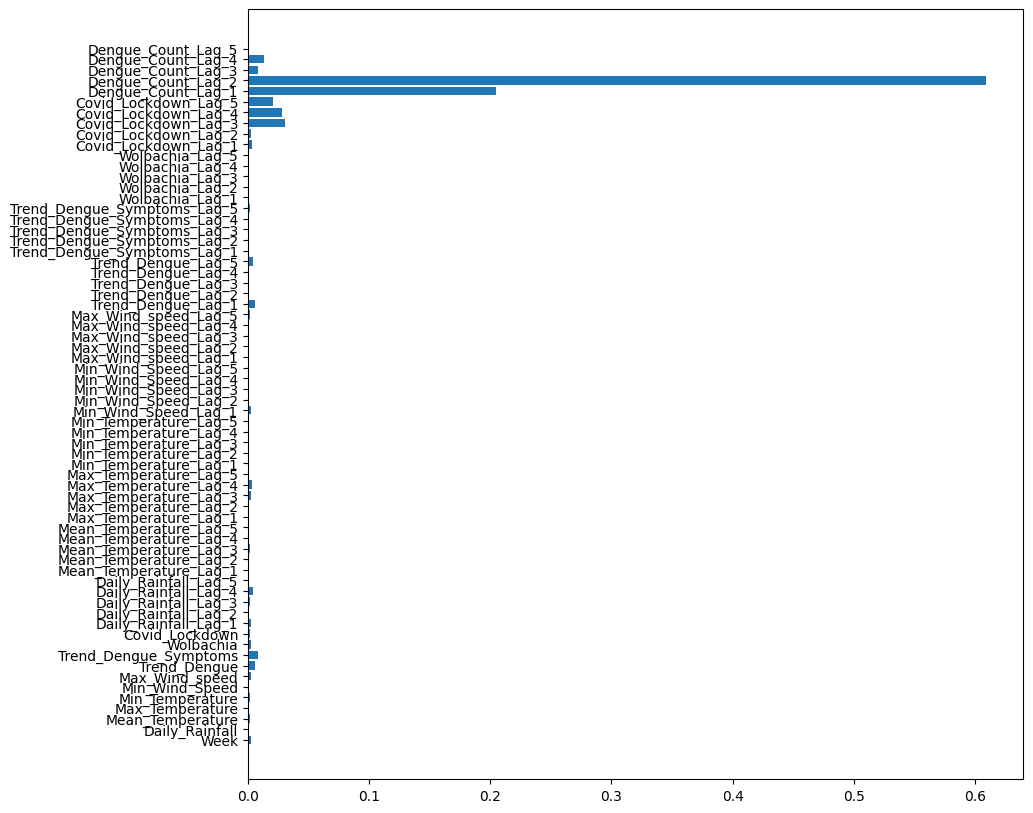

In [38]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Multiple time period prediction

In time series forecasting, it is often important to make predictions for multiple future time points rather than just one. When using models like XGBoost which are not natively built such prediction approaches, we need to perform predictions sequentially. First, we write a function to predict perform this sequential prediction.

In [103]:
from typing import Dict

def get_sequential_predictions(model, X,
                               dict_label_lags: Dict[int, str]):
    '''
    Get predictions using newly predicted labels as lagged labels.
    model: Model with predict method
    X: Features
    dict_label_lags: Dictionary with key as lagged label number, and value as column name of lagged label.
    '''

    X_pred = X.copy()

    label_lags = list(dict_label_lags.keys())                                          # Lagged label names
    lag_label_col_names = list(dict_label_lags.values())                                                 # Lag values for labels
    
    lag_label_col_locs = [X_pred.columns.get_loc(col) for col in lag_label_col_names]           # Integer index locations (use with iloc) of lagged labels

    pred_val = np.zeros(X_pred.shape[0])                                                        # Initialize predicted value array

    for i in range(X_pred.shape[0]):
        pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
        for k,j in enumerate(label_lags):                                                       # Add predicted value to X_val as lagged labels for subsequent rows
            try:
                X_pred.iloc[i+j,lag_label_col_locs[k]] = pred_val[i]
            except:
                continue
            
    pred_val = np.round(pred_val)                                                               # Round numbers to integers
    pred_val = np.clip(pred_val, 0, 10000000)                                                   # Clip numbers to keep positive and prevent extreme values
    
    return pred_val

We try a quick prediction using a rough xgboost model to see the effect of lagged labels

In [130]:
# Add external events
df_xgb = df_raw.copy()

# Wolbachia efforts from Oct 2016, corresponding to week 40 of 2016 at index 250
df_xgb['Wolbachia'] = 0
df_xgb.loc[250:,'Wolbachia'] = 1

# Workplace, public events, personal gatherings restricted from 13th March 2020, corresponding to week 11 of 2020, at index 432
# DORSCON from orange to yellow on 26th April 2022, corresponding to week 18 of 2022 at index 545
# https://askabout.io/covid-19/ask/what-is-the-government-response-timeline-for-singapore/
df_xgb['Covid_Lockdown'] = 0
df_xgb.loc[432:546,'Covid_Lockdown'] = 1

# Add construction work effects?

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Wolbachia','Covid_Lockdown']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = range(1, 6)
for lag in label_lags:
    df_xgb[f'Dengue_Count_Lag_{lag}'] = df_xgb['Dengue_Count'].shift(lag)    

# To train and test on only years between 2012 and 2018
df_xgb = df_xgb[df_xgb.Year<2019]

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Manually extracting two months (8 weeks) worth of data for prediction as test set
pred_weeks = 30                                     # USER INPUT: Length of period for prediction in weeks
pred_start = {'Year':2014, 'Week':20}               # USER INPUT: Start of prediction period

ind_pred = (df_xgb['Year'] == pred_start['Year']) & \
    (df_xgb['Week'] == pred_start['Week'])          # Boolean identifying index of prediction start week
ind_pred = df_xgb[ind_pred].index[0]                # Index of prediction start week
ind_pred = np.arange(ind_pred, ind_pred+pred_weeks) # Indices of prediction period

# Manually extracting train test sets
X_test = df_features.loc[ind_pred]
y_test = df_label.loc[ind_pred]
X_train = df_features.drop(ind_pred)
y_train = df_label.drop(ind_pred)

/tmp/ipykernel_132484/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
/tmp/ipykernel_132484/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
/tmp/ipykernel_132484/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract

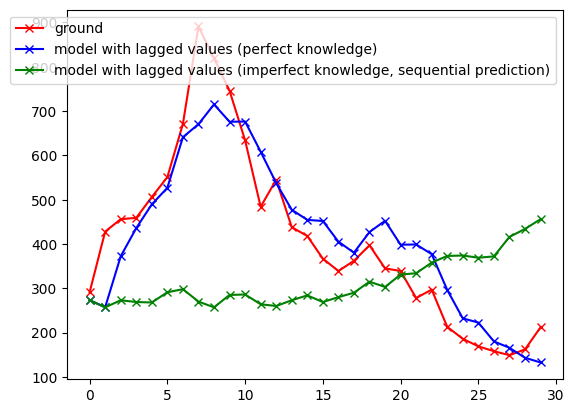

In [131]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

pred1 = model.predict(X_test) # Predict assuming perfect knowledge of past labels
pred2 = get_sequential_predictions(model, X_test, dict_label_lags={1:'Dengue_Count_Lag_1',
                                                                   2:'Dengue_Count_Lag_2',
                                                                   3:'Dengue_Count_Lag_3',
                                                                   4:'Dengue_Count_Lag_4',
                                                                   5:'Dengue_Count_Lag_5'} ) # Predict later labels using earlier predicted labels earlier in the sequence

plt.plot(y_test.reset_index(drop=True),'rx-',label='ground')
plt.plot(pred1,'bx-',label='model with lagged values (perfect knowledge)')
plt.plot(pred2,'gx-',label='model with lagged values (imperfect knowledge, sequential prediction)')
plt.legend()

As shown, using lagged labels is a double edged sword. When we have perfect knowledge of label (i.e. dengue count) values, the prediction is good (blue). However, when making a prediction three weeks into the future, we need good dengue counts from weeks 1 and 2, which we cannot know before hand. The green curve shows this sequential prediction, using _predicted_ dengue counts from weeks 1 and 2 to predict the value in week 3. As shown by the green curve, the prediction can be quite bad, as a wrong prediction early in the sequence can rapidly lead to bad results later.

For comparison, the prediction using a model without any lagged labels is shown below.

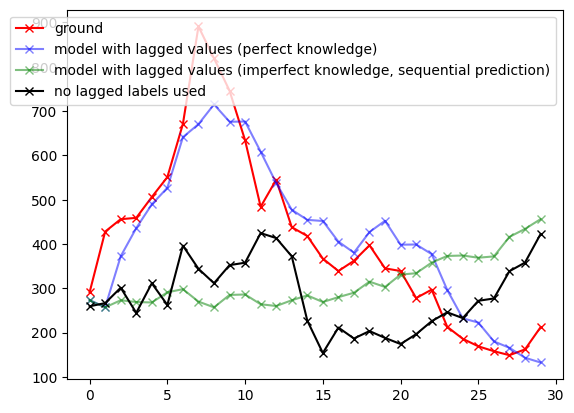

In [132]:
# Add external events
df_xgb = df_raw.copy()

# Wolbachia efforts from Oct 2016, corresponding to week 40 of 2016 at index 250
df_xgb['Wolbachia'] = 0
df_xgb.loc[250:,'Wolbachia'] = 1

# Workplace, public events, personal gatherings restricted from 13th March 2020, corresponding to week 11 of 2020, at index 432
# DORSCON from orange to yellow on 26th April 2022, corresponding to week 18 of 2022 at index 545
# https://askabout.io/covid-19/ask/what-is-the-government-response-timeline-for-singapore/
df_xgb['Covid_Lockdown'] = 0
df_xgb.loc[432:546,'Covid_Lockdown'] = 1

# Add construction work effects?

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Wolbachia','Covid_Lockdown']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

# To train and test on only years between 2012 and 2018
df_xgb = df_xgb[df_xgb.Year<2019]

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Manually extracting two months (8 weeks) worth of data for prediction as test set
pred_weeks = 30                                     # USER INPUT: Length of period for prediction in weeks
pred_start = {'Year':2014, 'Week':20}               # USER INPUT: Start of prediction period

ind_pred = (df_xgb['Year'] == pred_start['Year']) & \
    (df_xgb['Week'] == pred_start['Week'])          # Boolean identifying index of prediction start week
ind_pred = df_xgb[ind_pred].index[0]                # Index of prediction start week
ind_pred = np.arange(ind_pred, ind_pred+pred_weeks) # Indices of prediction period

# Manually extracting train test sets
X_test = df_features.loc[ind_pred]
y_test = df_label.loc[ind_pred]
X_train = df_features.drop(ind_pred)
y_train = df_label.drop(ind_pred)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

pred_no_lag = model.predict(X_test) # Predict without lagged label values

plt.plot(y_test.reset_index(drop=True),'rx-',label='ground')
plt.plot(pred1,'bx-',label='model with lagged values (perfect knowledge)',alpha=0.5)
plt.plot(pred2,'gx-',label='model with lagged values (imperfect knowledge, sequential prediction)',alpha=0.5)
plt.plot(pred_no_lag,'kx-',label='no lagged labels used')
plt.legend()

The new model without any lagged label values (black) appears to outperform the one with imperfect knowledge of lagged values (green), but is inferior to the one with perfect knowledge (blue).

The selection of actual label lags to use is important. Below we try using label lags of 3 and 4 only, which appears to be superior, at least in the early periods.

/tmp/ipykernel_132484/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
/tmp/ipykernel_132484/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
/tmp/ipykernel_132484/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract

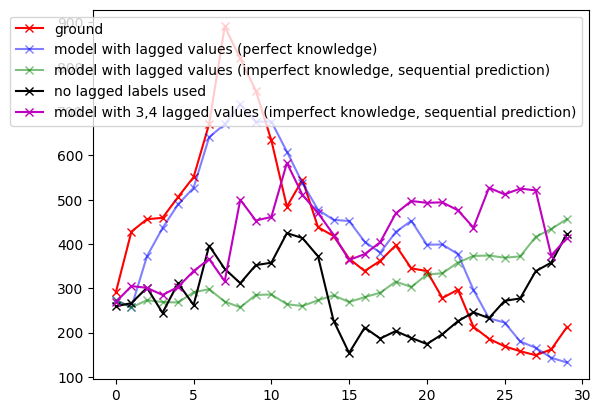

In [135]:
# Add external events
df_xgb = df_raw.copy()

# Wolbachia efforts from Oct 2016, corresponding to week 40 of 2016 at index 250
df_xgb['Wolbachia'] = 0
df_xgb.loc[250:,'Wolbachia'] = 1

# Workplace, public events, personal gatherings restricted from 13th March 2020, corresponding to week 11 of 2020, at index 432
# DORSCON from orange to yellow on 26th April 2022, corresponding to week 18 of 2022 at index 545
# https://askabout.io/covid-19/ask/what-is-the-government-response-timeline-for-singapore/
df_xgb['Covid_Lockdown'] = 0
df_xgb.loc[432:546,'Covid_Lockdown'] = 1

# Add construction work effects?

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Wolbachia','Covid_Lockdown']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = np.array([3,4])
for lag in label_lags:
    df_xgb[f'Dengue_Count_Lag_{lag}'] = df_xgb['Dengue_Count'].shift(lag)    

# To train and test on only years between 2012 and 2018
df_xgb = df_xgb[df_xgb.Year<2019]

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Manually extracting two months (8 weeks) worth of data for prediction as test set
pred_weeks = 30                                     # USER INPUT: Length of period for prediction in weeks
pred_start = {'Year':2014, 'Week':20}               # USER INPUT: Start of prediction period

ind_pred = (df_xgb['Year'] == pred_start['Year']) & \
    (df_xgb['Week'] == pred_start['Week'])          # Boolean identifying index of prediction start week
ind_pred = df_xgb[ind_pred].index[0]                # Index of prediction start week
ind_pred = np.arange(ind_pred, ind_pred+pred_weeks) # Indices of prediction period

# Manually extracting train test sets
X_test = df_features.loc[ind_pred]
y_test = df_label.loc[ind_pred]
X_train = df_features.drop(ind_pred)
y_train = df_label.drop(ind_pred)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

pred_34lags = get_sequential_predictions(model, X_test, dict_label_lags={3:'Dengue_Count_Lag_3',
                                                                   4:'Dengue_Count_Lag_4'} ) # Predict later labels using earlier predicted labels earlier in the sequence

plt.plot(y_test.reset_index(drop=True),'rx-',label='ground')
plt.plot(pred1,'bx-',label='model with lagged values (perfect knowledge)',alpha=0.5)
plt.plot(pred2,'gx-',label='model with lagged values (imperfect knowledge, sequential prediction)',alpha=0.5)
plt.plot(pred_no_lag,'kx-',label='no lagged labels used')
plt.plot(pred_34lags,'mx-',label='model with 3,4 lagged values (imperfect knowledge, sequential prediction)')
plt.legend()